In [856]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.autograd import Variable

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [857]:
 # Data load

data = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949')
data = data.iloc[:-1,:]
data

,date,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
0,2013-01-01,63.4,67.8,77.7,60.5,68.1,53.0,92.6,92.6,66.8,...,92.6,71.1,73.0,82.4,82.0,102.8,93.6,59.7,83.2,1
1,2013-02-01,63.3,67.2,77.4,60.2,67.7,52.9,92.5,90.9,66.6,...,92.8,70.9,72.9,82.0,81.7,102.8,93.6,59.1,83.0,1
2,2013-03-01,63.2,66.9,76.9,60.0,67.4,52.6,92.4,90.1,66.3,...,92.8,70.8,72.8,81.9,81.4,102.7,93.6,58.7,82.9,1
3,2013-04-01,63.3,67.1,76.4,59.8,67.4,52.6,92.4,90.0,66.3,...,93.5,70.7,73.2,82.3,81.7,102.7,93.9,58.6,82.9,1
4,2013-05-01,63.4,67.5,76.4,59.6,67.6,52.9,92.4,89.8,66.6,...,93.8,71.0,73.6,82.3,81.9,103.6,94.7,58.8,82.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,108.4,104.3,106.5,110.5,108.7,106.7,111.7,107.3,109.3,...,112.6,104.7,110.9,106.8,108.5,105.2,107.3,111.5,114.1,0
106,2021-11-01,109.5,104.8,107.2,111.7,110.2,107.3,113.2,107.7,110.7,...,114.8,105.3,111.6,107.9,109.5,106.6,108.4,112.9,115.9,0
107,2021-12-01,109.8,105.1,107.4,112.0,110.8,107.4,114.1,107.5,111.2,...,116.1,105.6,111.6,108.4,109.8,107.2,109.0,113.0,116.7,0
108,2022-01-01,109.8,105.1,107.4,111.8,110.8,107.3,114.3,107.5,111.3,...,116.9,105.6,111.5,108.7,109.8,107.1,109.2,113.0,116.8,0


In [858]:
df = pd.read_csv('경기도변수.csv')
df

,date,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
0,2013-01-01,73.5,64.75625,93.900000,80.1,102.868,92.728,5.78,82.689331,76.007636,1089.0,1841.1,1961.90,503.67,8413721.0,54632,13631
1,2013-02-01,73.2,64.42500,93.666667,79.8,90.009,93.038,5.66,82.871183,76.108044,1083.0,1857.1,2026.50,535.87,7268443.0,65640,14925
2,2013-03-01,73.1,64.22500,93.550000,79.6,101.388,92.952,5.54,83.162722,76.376687,1111.0,1862.4,2004.90,555.02,10160177.0,87563,17718
3,2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,1867.7,1964.00,563.87,9757932.0,106498,22790
4,2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,1870.3,2001.05,577.87,10837979.0,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,3543.4,2970.68,992.33,14689855.0,119686,29187
106,2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,3594.7,2839.01,965.63,14483042.0,111172,26593
107,2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,3620.1,2977.65,1033.98,19169150.0,101766,25669
108,2022-01-01,104.4,108.75000,111.383333,110.3,115.100,104.690,3.75,103.250891,104.790872,1205.5,3634.3,2663.34,872.87,13736304.0,87825,20544


lag 변수 생성

In [859]:
df.set_index('date', inplace=True)

In [860]:
lag_col= list(df.columns)

In [861]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
        
df.dropna(inplace=True)

In [862]:
df

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,...,코스닥_lag3,건축허용면적_lag1,건축허용면적_lag2,건축허용면적_lag3,거래량 전국_lag1,거래량 전국_lag2,거래량 전국_lag3,거래량 경기_lag1,거래량 경기_lag2,거래량 경기_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,...,503.67,10160177.0,7268443.0,8413721.0,87563.0,65640.0,54632.0,17718.0,14925.0,13631.0
2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,...,535.87,9757932.0,10160177.0,7268443.0,106498.0,87563.0,65640.0,22790.0,17718.0,14925.0
2013-06-01,73.2,64.55000,94.300000,79.5,99.722,92.710,5.05,83.978080,77.265688,1142.0,...,555.02,10837979.0,9757932.0,10160177.0,120393.0,106498.0,87563.0,25910.0,22790.0,17718.0
2013-07-01,72.8,64.36875,94.233333,79.1,99.907,92.909,5.09,84.230581,77.474299,1123.5,...,563.87,10007009.0,10837979.0,9757932.0,160468.0,120393.0,106498.0,33741.0,25910.0,22790.0
2013-08-01,72.5,64.17500,94.083333,78.8,96.115,93.238,5.06,84.582865,77.939035,1110.0,...,577.87,11233555.0,10007009.0,10837979.0,74944.0,160468.0,120393.0,16437.0,33741.0,25910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,...,1031.14,14652194.0,13946424.0,14591577.0,122333.0,133495.0,140102.0,33662.0,36154.0,39146.0
2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,...,1038.33,14689855.0,14652194.0,13946424.0,119686.0,122333.0,133495.0,29187.0,33662.0,36154.0
2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,...,1003.27,14483042.0,14689855.0,14652194.0,111172.0,119686.0,122333.0,26593.0,29187.0,33662.0


Data Exploration

LSTM Model

In [863]:
X_cols = list(df.columns)[:2]
y_cols = '수원시'

In [864]:
#테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = data['수원시'][-107:]

In [865]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit_transform(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용

y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

X_test

,seoul,Avg_1
date,,
2021-01-01,97.0,90.22500
2021-02-01,97.7,92.44375
2021-03-01,98.1,94.20625
2021-04-01,98.6,95.89375
2021-05-01,99.0,97.41250
2021-06-01,100.0,100.00000
2021-07-01,100.8,101.94375
2021-08-01,101.7,104.06250
2021-09-01,102.7,105.82500


In [866]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (93, 2)
test set :  (14, 2)


In [867]:
# numpy -> tensor 변환
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(93,1)
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(14,1)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = torch.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
X_test = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = torch.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [868]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([93, 1, 2])
X_test : torch.Size([14, 1, 2])
y_train : torch.Size([93, 1, 1])
y_test : torch.Size([14, 1, 1])


Building a Model

In [869]:
class LSTM_Jun(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 

        super(LSTM_Jun, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size

        self.hidden_size = hidden_size

        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

        self.layer_1 = nn.Linear(hidden_size, 256)

        self.layer_2 = nn.Linear(256,256)

        self.layer_3 = nn.Linear(256,128)

        self.layer_out = nn.Linear(128, num_classes)

        self.relu = nn.ReLU() #Activation Func



    def forward(self,x):

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State

        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States



        output, (hn, cn) = self.lstm(x, (h_0, c_0))



        hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network

        out = self.relu(hn) #pre-processing for first layer

        out = self.layer_1(out) # first layer

        out = self.relu(out) # activation func relu

        out = self.layer_2(out)

        out = self.relu(out)

        out = self.layer_3(out)

        out = self.relu(out)

        out = self.layer_out(out) #Output layer

        return out

# Code Main

num_epochs = 500
learning_rate = 0.005

input_size = int(len(X_cols))

hidden_size = 2 # number of features in hidden state

num_layers = 1

num_classes = int(len(y_cols))



LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, X_train.shape[1]).to(device)



loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(LSTM_Jun.parameters(), lr = learning_rate)



for epoch in range(num_epochs) : 

    outputs = LSTM_Jun.forward(X_train.to(device))




    optimizer.zero_grad()

    loss = loss_function(outputs, y_train.to(device))

    loss.backward()

    optimizer.step() # improve from loss = back propagation

    if epoch % 100 == 0 :

        print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))

Epoch : 0, loss : 0.06357
Epoch : 100, loss : 0.02066
Epoch : 200, loss : 0.02066
Epoch : 300, loss : 0.02066
Epoch : 400, loss : 0.02066


In [874]:
# Estimated Value

test_predict = LSTM_Jun(X_train.to(device)) #Forward Pass
predict_data = test_predict.detach().cpu().numpy() #numpy conversion
predict_data = scaler.inverse_transform(predict_data) #inverse normalization(Min/Max)
y_pred = predict_data[:,0]
y_pred

array([71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86882,
       71.86882, 71.86882, 71.86882, 71.86882, 71.86882, 71.86

In [873]:
# Real Value

real_data = y_test.data.numpy().reshape(14,1)# Real value

real_data = scaler.inverse_transform(real_data) #inverse normalization 

real_data
y_test = real_data[:,0]

In [737]:
pred_values_ceiled  = list(pred_values.flatten())

In [738]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [739]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [740]:
score_table

,True,Pred
0,91.700001,81.141294
1,93.400000,80.234776
2,94.700000,79.330971
3,96.300001,78.450620
4,97.300001,77.610024
5,99.999999,76.823328
6,102.400000,76.100447
7,104.700000,75.449293
8,106.500000,74.873990
9,108.399999,74.376263


In [741]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
MAPE= np.mean(np.abs((score_table['True'] - score_table['Pred']) / score_table['True']))
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [742]:
print("MSE : {0}, RMSE : {1}, MAPE : {2}, SCORE : {3}".format(MSE, RMSE, MAPE, score))

MSE : 764.9854168190549, RMSE : 27.658369742612358, MAPE : 0.25034974930539383, SCORE : 92.7389575477365


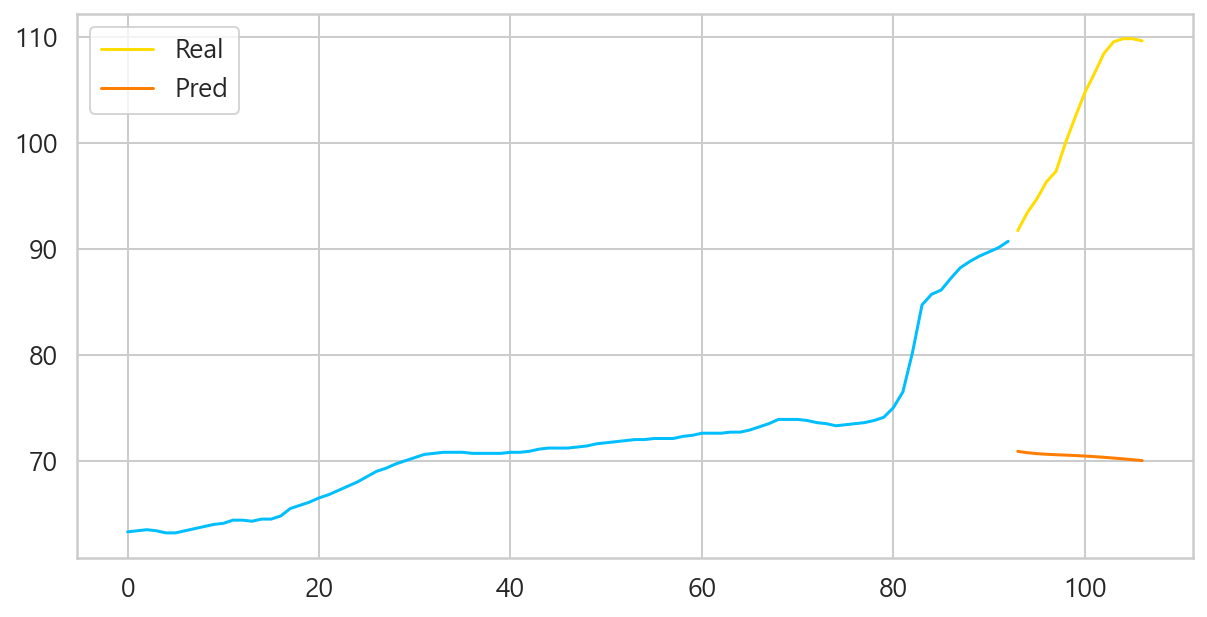

In [717]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [704]:
PATH = f'./model.pt'
torch.save(model, f'./model.pt')

In [705]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

Predicting future cases

In [650]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [651]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [652]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[74.52408612370492,
 74.207553511858,
 73.8239729821682,
 73.39816912412644,
 72.95745523571968,
 72.52527267336846,
 72.11884935498237,
 71.7490754634142,
 71.42146032154561,
 71.13740729987622,
 70.89548802971841,
 70.69250968694688,
 70.52433854341507,
 70.38647631406785]

In [653]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1, freq = 'MS',
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.DataFrame(
  data=predicted_cases,
  index=predicted_index
)
predicted_cases

,0
2022-03-01,74.524086
2022-04-01,74.207554
2022-05-01,73.823973
2022-06-01,73.398169
2022-07-01,72.957455
2022-08-01,72.525273
2022-09-01,72.118849
2022-10-01,71.749075
2022-11-01,71.421460
2022-12-01,71.137407


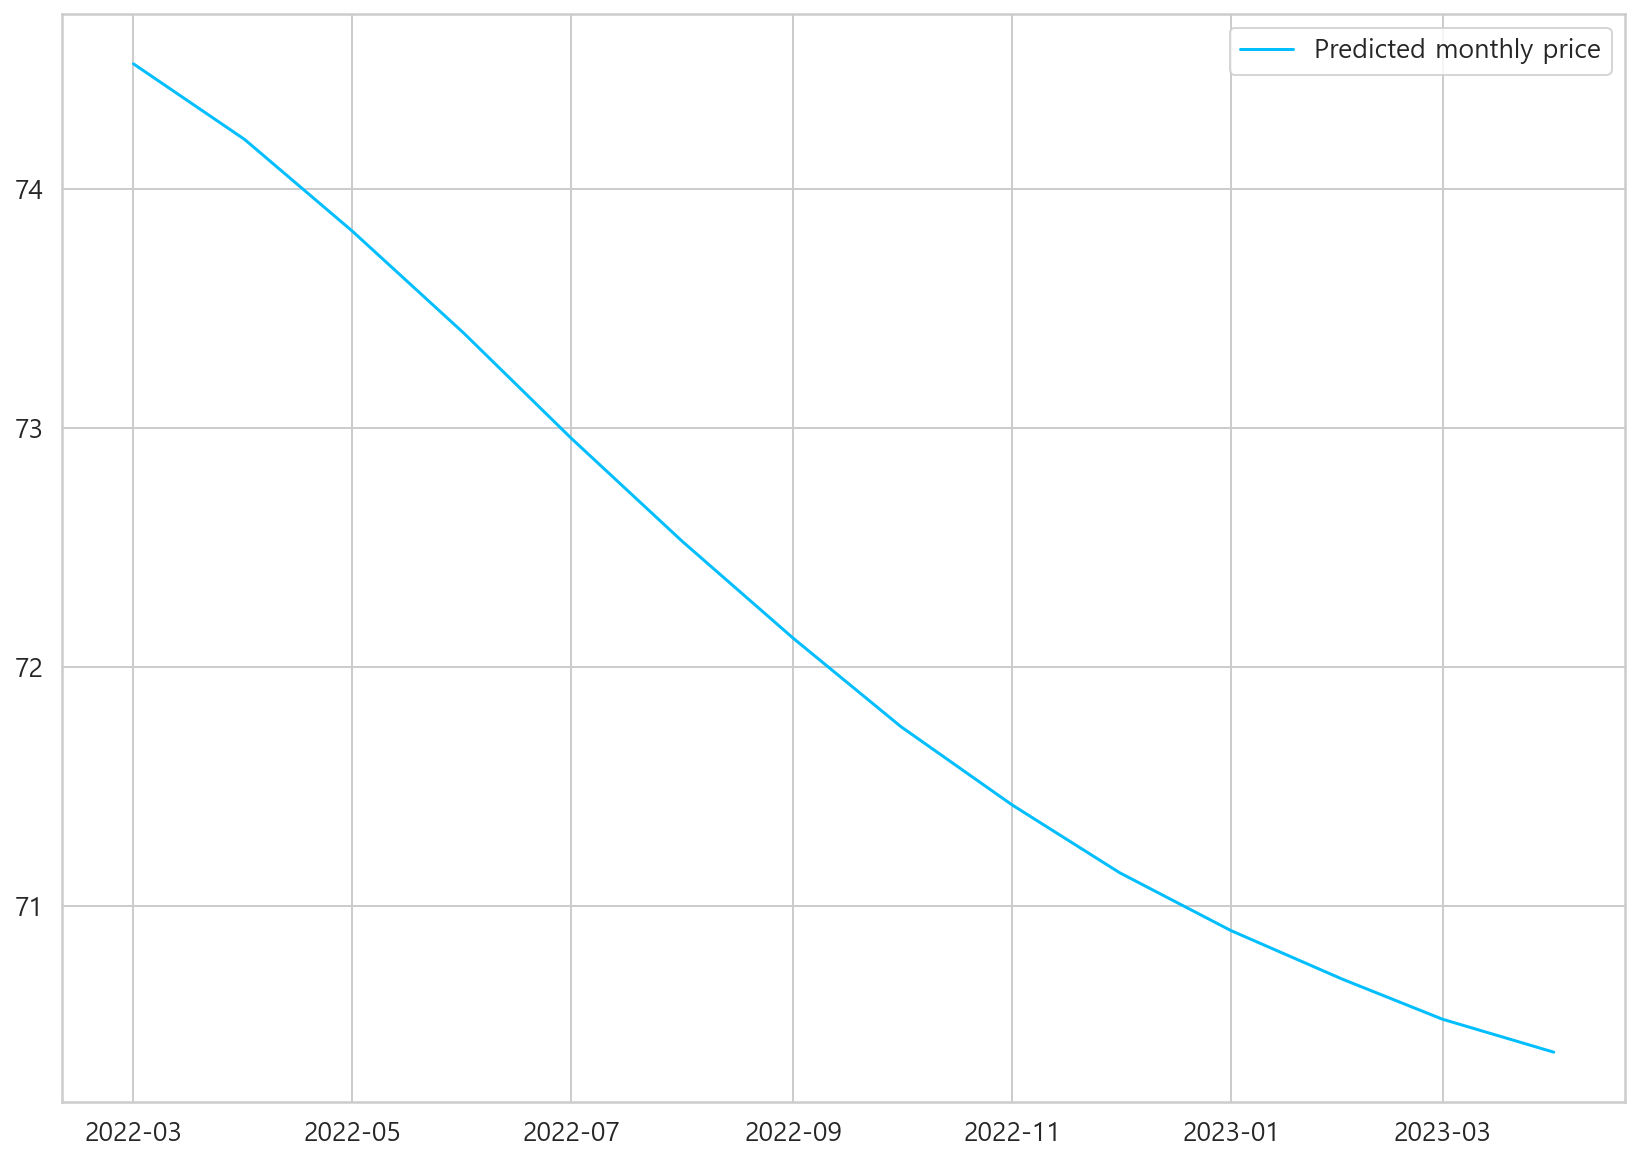

In [654]:
plt.plot(predicted_cases, label='Predicted monthly price')
plt.legend();

In [655]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [656]:
preds_

,0
2022-03-01,74.524086
2022-04-01,74.207554
2022-05-01,73.823973
2022-06-01,73.398169
2022-07-01,72.957455
2022-08-01,72.525273
2022-09-01,72.118849
2022-10-01,71.749075
2022-11-01,71.421460
2022-12-01,71.137407


In [657]:
y = pd.DataFrame(data =data['수원시'][-107:].values,index = date)
y.index.name = ''
y

,0
,
2013-04-01,63.3
2013-05-01,63.4
2013-06-01,63.5
2013-07-01,63.4
2013-08-01,63.2
...,...
2021-10-01,108.4
2021-11-01,109.5
2021-12-01,109.8


In [658]:
plt.figure(figsize=(25,5))
plt.plot(y,label='real')
plt.plot(preds_, label='predict')
plt.xticks(rotation=90)


plt.legend()

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'

<Figure size 1800x360 with 1 Axes>